In [ ]:
# def process_data(input_file, output_file):
#     with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
#         for line in infile:
#             # Split the line into its components
#             parts = line.strip().split(',')
            
#             # Check if we have at least 5 parts (file path + 4 features)
#             if len(parts) >= 5:
#                 # Replace 'None' with 'mixed' in the 4th column (3rd feature)
#                 if parts[3] == 'None':
#                     parts[3] = 'mixed'
                
#                 # Replace 'None' with 'unknown' in other columns
#                 for i in range(1, len(parts)):
#                     if i != 3 and parts[i] == 'None':
#                         parts[i] = 'unknown'
            
#             # Join the parts back into a line and write to output file
#             outfile.write(','.join(parts) + '\n')

# # Usage
# input_file = '/home/zakaria/workspace/ai-photo-enhancer/dataset/categories.txt'
# output_file = 'processed_data.txt'
# process_data(input_file, output_file)

In [ ]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, 
                 augment_data=True, use_txt_features=False):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), 
                              interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), 
                              interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            # One-hot encode the features using MultiLabelBinarizer
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            # Return categorical indices
            cat_features = [self.feature_to_idx[cat][feat] 
                            for cat, feat in 
                            zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot' or 'categorical'.")

    def collate_fn(self, batch):
        sources, features, targets = zip(*batch)
        sources = torch.stack(sources)
        targets = torch.stack(targets)
        
        if self.use_txt_features in ["one_hot", "categorical"]:
            features = torch.stack(features)
        else:
            features = None

        return sources, features, targets

In [ ]:
from torch.utils.data import DataLoader

a =FiveKDataset(244,use_txt_features='one_hot')
d = DataLoader(a, batch_size=32 , shuffle = True)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(a[0][0].permute(1,2,0))

In [ ]:
a.feature_to_idx

In [ ]:
a.features['a0001-jmac_DSC1459.jpg']

In [ ]:
a.img_files

In [ ]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from transformers import BertTokenizer, BertModel

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, augment_data=True, use_txt_features=False):
        # ... [previous initialization code remains the same] ...

        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }
        
        if self.use_txt_features == "embedded":
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
            self.bert_model.eval()  # Set to evaluation mode

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            # One-hot encode the features using MultiLabelBinarizer
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            # Return categorical indices
            cat_features = [self.feature_to_idx[cat][feat] for cat, feat in zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        elif self.use_txt_features == "embedded":
            # Combine features into a single string
            feature_text = " ".join(self.features[img_name])
            
            # Tokenize and get BERT embeddings
            inputs = self.tokenizer(feature_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = self.bert_model(**inputs)
            
            # Use the [CLS] token embedding as the feature representation
            embedded_features = outputs.last_hidden_state[:, 0, :]  # Shape: (1, 768)
            embedded_features = embedded_features.squeeze(0)  # Shape: (768,)
            
            return source, embedded_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot', 'categorical', or 'embedded'.")

    def collate_fn(self, batch):
        sources, features, targets = zip(*batch)
        sources = torch.stack(sources)
        targets = torch.stack(targets)
        
        if self.use_txt_features in ["one_hot", "categorical", "embedded"]:
            features = torch.stack(features)
        else:
            features = None

        return sources, features, targets

In [ ]:
a = FiveKDataset(244,use_txt_features='embedded')

In [ ]:
a[0][1].shape

In [3]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, 
                 augment_data=False, use_txt_features=False,device='cuda'):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        self.device = device #used for precomputing embedded features
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }
        
        self.precomputed_features = {}
        if self.use_txt_features == "embedded":
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased').to(self.device)
            self.bert_model.eval()  # Set to evaluation mode
            self.precompute_embeddings()

    def precompute_embeddings(self):
        print("Precomputing embeddings...")
        for img_name in tqdm(self.img_files):
            feature_text = " ".join(self.features[img_name])
            inputs = self.tokenizer(feature_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = self.bert_model(**inputs.to(self.device))
            embedded_features = outputs.last_hidden_state[:, 0, :].squeeze(0)  # Shape: (768,)
            self.precomputed_features[img_name] = embedded_features.to(self.device)
        del self.bert_model
        del self.tokenizer
        print("Embeddings precomputed and stored.")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            cat_features = [self.feature_to_idx[cat][feat] for cat, feat in zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        elif self.use_txt_features == "embedded":
            return source, self.precomputed_features[img_name], target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot', 'categorical', or 'embedded'.")

    def collate_fn(self, batch):
        sources, features, targets = zip(*batch)
        sources = torch.stack(sources)
        targets = torch.stack(targets)
        
        if self.use_txt_features in ["one_hot", "categorical", "embedded"]:
            features = torch.stack(features)
        else:
            features = None

        return sources, features, targets

In [4]:
dataset = FiveKDataset(image_size=64, mode="train", use_txt_features="embedded")

Precomputing embeddings...


 51%|█████     | 2299/4500 [00:20<00:19, 112.35it/s]


KeyboardInterrupt: 

In [33]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from transformers import BertTokenizer, BertModel, CLIPProcessor, CLIPModel
from tqdm import tqdm

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, 
                 augment_data=False, use_txt_features=False,device='cuda'):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories_2.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        self.device = device
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) 
                           for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }

        self.precomputed_bert_features = {}
        self.precomputed_clip_features = {}
        
        if self.use_txt_features == "embedded":
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
            self.bert_model.eval()
            self.bert_model.to(self.device)
            self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
            self.clip_model.eval()
            self.clip_model.to(self.device)
            self.precompute_features()

    def precompute_features(self):
        print("Precomputing BERT and CLIP features...")
        for img_name in tqdm(self.img_files):
            # Precompute BERT features
            feature_text = " ".join(self.features[img_name])
            inputs = self.tokenizer(feature_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                
                outputs = self.bert_model(**inputs.to(self.device))
            bert_features = outputs.last_hidden_state[:, 0, :].squeeze(0)  # Shape: (768,)
            self.precomputed_bert_features[img_name] = bert_features.cpu()

            # Precompute CLIP features
            image_path = os.path.join(self.IMGS_PATH, 'input', img_name)
            image = read_image(image_path)
            if self.resize:
                image = F.resize(image, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            clip_inputs = self.clip_processor(images=image, return_tensors="pt")
            with torch.no_grad():
                
                clip_features = self.clip_model.get_image_features(**clip_inputs.to(self.device))

            self.precomputed_clip_features[img_name] = clip_features.squeeze(0).cpu()  # Shape: (512,)
        del self.bert_model
        del self.tokenizer    
        del self.clip_model
        del self.clip_processor  
        print("BERT and CLIP features precomputed and stored.")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            cat_features = [self.feature_to_idx[cat][feat] for cat, feat in zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        elif self.use_txt_features == "embedded":
            bert_features = self.precomputed_bert_features[img_name]
            clip_features = self.precomputed_clip_features[img_name]
            return source, bert_features, clip_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot', 'categorical', or 'embedded'.")

    def collate_fn(self, batch):
        if self.use_txt_features == "embedded":
            sources, bert_features, clip_features, targets = zip(*batch)
            sources = torch.stack(sources)
            bert_features = torch.stack(bert_features)
            clip_features = torch.stack(clip_features)
            targets = torch.stack(targets)
            return sources, bert_features, clip_features, targets
        else:
            sources, features, targets = zip(*batch)
            sources = torch.stack(sources)
            targets = torch.stack(targets)
            if self.use_txt_features in ["one_hot", "categorical"]:
                features = torch.stack(features)
            else:
                features = None
            return sources, features, targets

In [34]:
dataset = FiveKDataset(image_size=64, mode="train", use_txt_features="one_hot")

In [35]:
dataset.feature_to_idx

{'Location': {'indoor': 0, 'outdoor': 1, 'unknown_location': 2},
 'Time': {'day': 0, 'dusk': 1, 'night': 2, 'unknown_time': 3},
 'Light': {'artificial': 0, 'mixed': 1, 'sun_sky': 2},
 'Subject': {'abstract': 0,
  'animals': 1,
  'man_made': 2,
  'nature': 3,
  'people': 4,
  'unknown_subject': 5}}

In [39]:
dataset.mlb.classes_

array(['abstract', 'animals', 'artificial', 'day', 'dusk', 'indoor',
       'man_made', 'mixed', 'nature', 'night', 'outdoor', 'people',
       'sun_sky', 'unknown_location', 'unknown_subject', 'unknown_time'],
      dtype=object)

In [38]:
dataset[0][1]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

In [32]:
import csv

# Input and output file names
input_file = '../dataset/processed_categories.txt'
output_file = '../dataset/processed_categories_2.txt'

# Read the input file
with open(input_file, 'r') as file:
    reader = csv.reader(file)
    data = list(reader)

# Process the data
for row in data:
    if len(row) >= 5:  # Ensure the row has at least 5 elements
        if row[1] == 'unknown':
            row[1] = 'unknown_location'
        if row[2] == 'unknown':
            row[2] = 'unknown_time'
        if row[4] == 'unknown':
            row[4] = 'unknown_subject'

# Write the processed data to the output file
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

print(f"Processing complete. Results saved to {output_file}")

Processing complete. Results saved to ../dataset/processed_categories_2.txt


In [51]:
img.numpy().shape

(3, 64, 64)

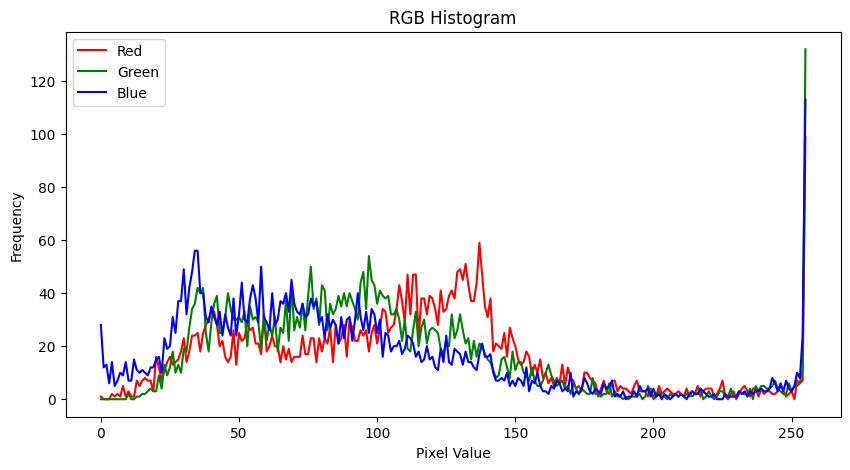

In [61]:
def compute_and_display_histogram(img_rgb):
    # Read the image

    
    # Compute histograms for each channel
    hist_r = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])

    # Plot the histograms
    plt.figure(figsize=(10, 5))
    plt.title("RGB Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    
    plt.plot(hist_r, color='red', label='Red')
    plt.plot(hist_g, color='green', label='Green')
    plt.plot(hist_b, color='blue', label='Blue')
    
    plt.legend()
    plt.show()

# Use the function'path/to/your/image.jpg'
compute_and_display_histogram(img.permute(1,2,0).numpy())

In [68]:
import cv2
img = dataset[0][0]
cv2.calcHist([img.permute(1,2,0).numpy()], [0,1,2], None, [256,256,256], [0,256,0,256,0,256]).shape

(256, 256, 256)

In [71]:
import cv2
import numpy as np

def extract_color_features(image_path):
    # Read the image
    img_rgb =image_path

    # Compute histograms
    hist_r = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])

    # Normalize histograms
    hist_r = hist_r / hist_r.sum()
    hist_g = hist_g / hist_g.sum()
    hist_b = hist_b / hist_b.sum()

    # Compute features
    features = []
    for hist in [hist_r, hist_g, hist_b]:
        mean = np.mean(hist)
        std = np.std(hist)
        skew = np.mean(((hist - mean) / std) ** 3) if std != 0 else 0
        kurtosis = np.mean(((hist - mean) / std) ** 4) - 3 if std != 0 else -3
        features.extend([mean, std, skew, kurtosis])

    # Add more features
    brightness = np.mean(img_rgb)
    contrast = np.max(img_rgb) - np.min(img_rgb)
    features.extend([brightness, contrast])

    return np.array(features)

# Use the function
features = extract_color_features(img.permute(1,2,0).numpy())
print(features)

[3.90625000e-03 3.46196326e-03 1.34315693e+00 3.62654781e+00
 3.90625000e-03 3.91399115e-03 1.81032562e+00 8.91269302e+00
 3.90625000e-03 3.60372406e-03 1.58656263e+00 5.95933533e+00
 9.78079427e+01 2.55000000e+02]


In [76]:
import cv2
import numpy as np
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

def extract_image_features(image_path):
    # Read the image
    # img = cv2.imread(image_path)
    img_rgb = image_path
    
    # Convert to float and add small epsilon to avoid log(0)
    img_float = img_rgb.astype(float) + 1e-8
    
    # Compute log-intensity
    log_intensity = np.log(np.sum(img_float, axis=2))
    
    features = {}
    
    # 1. Intensity distributions
    features['log_intensity_mean'] = np.mean(log_intensity)
    percentiles = np.percentile(log_intensity, np.arange(2, 101, 2))
    features['log_intensity_percentiles'] = percentiles
    
    # Compute for Gaussian-convolved versions
    for sigma in [10, 30]:
        log_intensity_blurred = gaussian_filter(log_intensity, sigma=sigma)
        percentiles = np.percentile(log_intensity_blurred, np.arange(2, 101, 2))
        features[f'log_intensity_percentiles_sigma_{sigma}'] = percentiles
    
    # 2. Equalization curves
    hist, bins = np.histogram(log_intensity.flatten(), bins=256, range=(0, np.max(log_intensity)))
    cdf = np.cumsum(hist) / np.sum(hist)
    features['equalization_curve'] = cdf
    
    # 3. Detail-weighted equalization curves
    for sigma in [1, 100, 200]:
        gradient_x = cv2.Sobel(log_intensity, cv2.CV_64F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(log_intensity, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        gradient_magnitude = gaussian_filter(gradient_magnitude, sigma=sigma)
        
        weighted_hist, _ = np.histogram(log_intensity.flatten(), bins=256, range=(0, np.max(log_intensity)), 
                                        weights=gradient_magnitude.flatten())
        weighted_cdf = np.cumsum(weighted_hist) / np.sum(weighted_hist)
        features[f'detail_weighted_equalization_curve_sigma_{sigma}'] = weighted_cdf
    
    # 4. Highlight clipping
    intensity = np.sum(img_rgb, axis=2)
    for clip_percent in [1, 2, 3, 5, 10, 15]:
        clip_value = np.percentile(intensity, 100 - clip_percent)
        features[f'highlight_clip_{clip_percent}'] = clip_value
    
    # 5. Spatial distributions
    height, width = log_intensity.shape
    y, x = np.mgrid[0:height, 0:width]
    
    for i in range(10):
        lower = np.percentile(log_intensity, i*10)
        upper = np.percentile(log_intensity, (i+1)*10)
        mask = (log_intensity >= lower) & (log_intensity < upper)
        
        if np.sum(mask) > 0:
            x_masked = x[mask]
            y_masked = y[mask]
            
            mean_x = np.mean(x_masked)
            mean_y = np.mean(y_masked)
            cov = np.cov(x_masked, y_masked)
            
            eigenvalues, eigenvectors = np.linalg.eig(cov)
            area = np.pi * np.prod(np.sqrt(eigenvalues))
            
            features[f'spatial_distribution_area_{i}'] = area / np.sum(mask)
            features[f'spatial_distribution_center_x_{i}'] = mean_x / width
            features[f'spatial_distribution_center_y_{i}'] = mean_y / height
        else:
            features[f'spatial_distribution_area_{i}'] = 0
            features[f'spatial_distribution_center_x_{i}'] = 0.5
            features[f'spatial_distribution_center_y_{i}'] = 0.5
    
    feature_vector = []
    for key, value in features.items():
        if isinstance(value, np.ndarray):
            feature_vector.extend(value.flatten())
        else:
            feature_vector.append(value)
    
    feature_vector = np.array(feature_vector)

    # Normalize the feature vector
    min_vals = np.min(feature_vector)
    max_vals = np.max(feature_vector)
    
    # Avoid division by zero
    if max_vals - min_vals != 0:
        normalized_feature_vector = (feature_vector - min_vals) / (max_vals - min_vals)
    else:
        normalized_feature_vector = np.zeros_like(feature_vector)

    return features, normalized_feature_vector

# Usage
image_path = dataset[0][0].permute(1, 2, 0).numpy()
feature_dict, feature_vector = extract_image_features(image_path)

print(f"Number of features: {len(feature_vector)}")
print(f"Shape of feature vector: {feature_vector.shape}")

# Print first few features from the dictionary
for key, value in list(feature_dict.items())[:5]:
    if isinstance(value, np.ndarray):
        print(f"{key}: array of shape {value.shape}")
    else:
        print(f"{key}: {value}")

# Print first few values from the feature vector
print("First 10 values of feature vector:", feature_vector[:10])

Number of features: 1211
Shape of feature vector: (1211,)
log_intensity_mean: 5.551895349778497
log_intensity_percentiles: array of shape (50,)
log_intensity_percentiles_sigma_10: array of shape (50,)
log_intensity_percentiles_sigma_30: array of shape (50,)
equalization_curve: array of shape (256,)
First 10 values of feature vector: [0.00725738 0.00582115 0.00604572 0.00614442 0.00624281 0.00634252
 0.00642177 0.00648738 0.00657574 0.00665045]


In [80]:
feature_vector

array([0.00725738, 0.00582115, 0.00604572, ..., 0.00200092, 0.00026183,
       0.00028563])

In [81]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter, gaussian_gradient_magnitude
from scipy.stats import norm

def extract_image_features(images):
    def log_intensity(img):
        return np.log1p(np.sum(img, axis=2))

    def compute_percentiles(data, percentiles):
        return np.percentile(data, percentiles)

    def equalization_curve(img):
        hist, bins = np.histogram(img.flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()
        return cdf_normalized

    def detail_weighted_equalization_curve(img, sigma):
        gradient_magnitude = gaussian_gradient_magnitude(img, sigma=sigma)
        weighted_hist, _ = np.histogram(img.flatten(), weights=gradient_magnitude.flatten(), bins=256, range=[0, 256])
        cdf = weighted_hist.cumsum()
        cdf_normalized = cdf * weighted_hist.max() / cdf.max()
        return cdf_normalized

    def highlight_clipping(img, clip_levels):
        sorted_pixels = np.sort(img.flatten())
        total_pixels = len(sorted_pixels)
        clipping_values = [sorted_pixels[int(total_pixels * clip)] for clip in clip_levels]
        return clipping_values

    def spatial_distribution(img, bins=10):
        intervals = np.linspace(np.min(img), np.max(img), bins + 1)
        features = []
        for i in range(bins):
            mask = (img >= intervals[i]) & (img < intervals[i + 1])
            if np.sum(mask) == 0:
                features.extend([0, 0, 0])
            else:
                x, y = np.where(mask)
                mu_x, mu_y = np.mean(x), np.mean(y)
                cov = np.cov(x, y)
                area = np.sqrt(np.linalg.det(cov))
                features.extend([area, mu_x, mu_y])
        return features

    features = []
    percentiles = np.arange(0, 102, 2)
    clip_levels = [0.01, 0.02, 0.03, 0.05, 0.10, 0.15]

    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        log_img = log_intensity(img)

        img_features = []

        # Intensity distributions
        img_features.append(np.mean(log_img))
        img_features.extend(compute_percentiles(log_img, percentiles))

        # Gaussian convolved versions
        for sigma in [10, 30]:
            blurred_img = gaussian_filter(log_img, sigma=sigma)
            img_features.extend(compute_percentiles(blurred_img, percentiles))

        # Equalization curves
        img_features.extend(equalization_curve(img))

        # Detail-weighted equalization curves
        for sigma in [1, 100, 200]:
            img_features.extend(detail_weighted_equalization_curve(img, sigma))

        # Highlight clipping
        img_features.extend(highlight_clipping(img, clip_levels))

        # Spatial distributions
        img_features.extend(spatial_distribution(img))

        features.append(np.array(img_features))

    # Normalize features
    features = np.array(features)
    features = (features - features.mean(axis=0)) / features.std(axis=0)

    return features


In [88]:
dataset[0][0].unsqueeze(0).numpy().shape

(1, 3, 64, 64)

In [90]:
extract_image_features(dataset[0][0].permute(1, 2, 0).unsqueeze(0).numpy())

AxisError: axis 2 is out of bounds for array of dimension 2

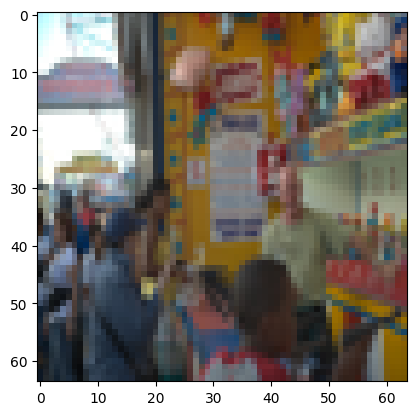

In [41]:
import matplotlib.pyplot as plt

plt.imshow(dataset[0][0].permute(1, 2, 0))

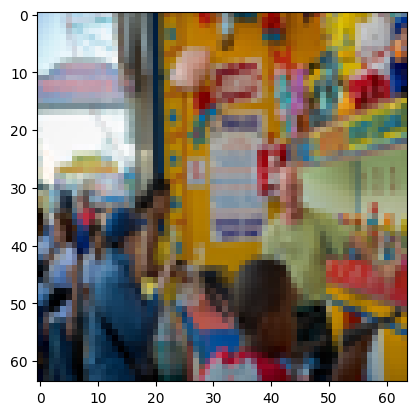

In [43]:
plt.imshow(dataset[0][-1].permute(1, 2, 0))

In [20]:
import torch
import torch.nn as nn

class CrossModalAttention(nn.Module):
    def __init__(self, bert_dim=768, clip_dim=512, resnet_dim=512, common_dim=512):
        super().__init__()
        self.bert_projection = nn.Linear(bert_dim, common_dim)
        self.clip_projection = nn.Linear(clip_dim, common_dim)
        self.resnet_projection = nn.Linear(resnet_dim, common_dim)
        
        self.attention = nn.MultiheadAttention(embed_dim=common_dim, num_heads=8)
        
    def forward(self, bert_features, clip_features, resnet_features):
        # Project all features to a common dimension
        q = self.bert_projection(bert_features)
        k = self.clip_projection(clip_features)
        v = self.resnet_projection(resnet_features)
        
        # Reshape tensors to (seq_len, batch_size, common_dim)
        q = q.unsqueeze(0)  # (1, batch_size, common_dim)
        k = k.unsqueeze(0)  # (1, batch_size, common_dim)
        v = v.unsqueeze(0)  # (1, batch_size, common_dim)
        
        # Compute attention
        attn_output, _ = self.attention(query=q, key=k, value=v)
        
        return attn_output.squeeze(0)  # (batch_size, common_dim)

# Test the module
att = CrossModalAttention()

# Create dummy data
batch_size = 32
res_f = torch.rand(batch_size, 512)
bert_f = torch.rand(batch_size, 768)
clip_f = torch.rand(batch_size, 512)

# Forward pass
out = att(bert_f, clip_f, res_f)
print(out.shape)  # Should print torch.Size([32, 512])

torch.Size([32, 512])


In [23]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(att)

1969664

In [43]:
from tensordict import TensorDict
import torch
from torchrl.data import TensorDictReplayBuffer,LazyMemmapStorage
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
rb = TensorDictReplayBuffer(
                        storage=LazyMemmapStorage(100,), sampler=SamplerWithoutReplacement())
batch_observation= TensorDict(
            {
                "batch_images":TensorDict({'obs':torch.ones(32,1,1,15)},batch_size = [32]),
                "ts_features":torch.ones(32,1,1,15),
                "ims_features":torch.ones(32,1,1,15),
            },
            batch_size = [32],
        )
rb.extend(batch_observation)

batch_observation= TensorDict(
            {
                "batch_images":TensorDict({'obs':torch.zeros(32,1,1,15)},batch_size = [32]),
                "ts_features":torch.zeros(32,1,1,15),
                "ims_features":torch.zeros(32,1,1,15),
            },
            batch_size = [32],
        )
rb.extend(batch_observation)

tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [70]:
data=rb.sample(1)
print(data['batch_images']['obs'])
print(data['ts_features'])

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])


In [41]:
def test1(batch_images,ts_features,ims_features):
    print(batch_images.shape)
    print(ts_features.shape)
    print(ims_features.shape)

In [42]:
def test(**kwargs):
    actions = kwargs.pop('actions')
    test1(**kwargs)

In [44]:
test(**batch_observation,actions=1)


torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])


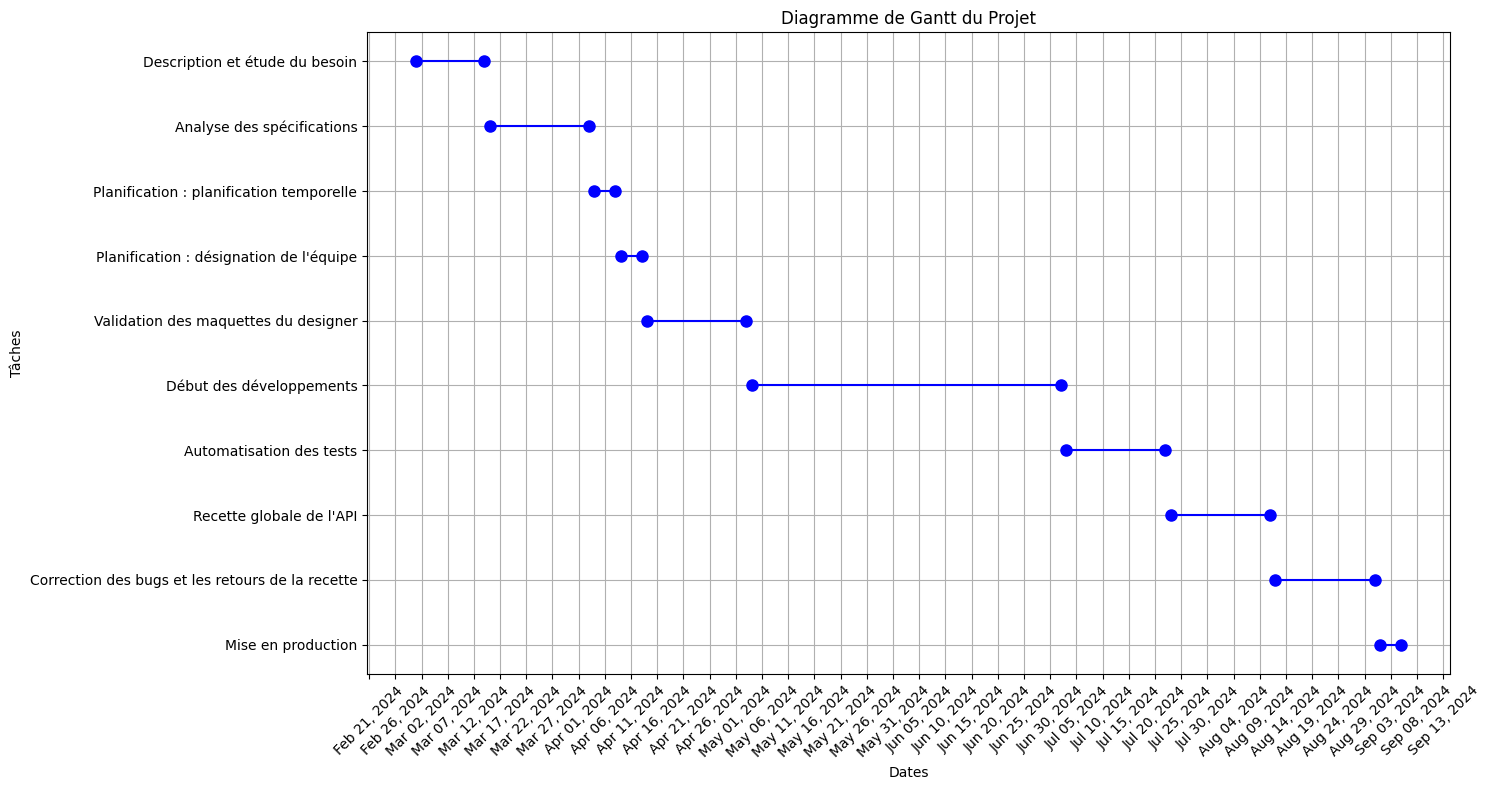

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Définir les tâches avec les dates de début et de fin
tasks = [
    {"Task": "Description et étude du besoin", "Start": "2024-03-01", "End": "2024-03-14"},
    {"Task": "Analyse des spécifications", "Start": "2024-03-15", "End": "2024-04-03"},
    {"Task": "Planification : planification temporelle", "Start": "2024-04-04", "End": "2024-04-08"},
    {"Task": "Planification : désignation de l'équipe", "Start": "2024-04-09", "End": "2024-04-13"},
    {"Task": "Validation des maquettes du designer", "Start": "2024-04-14", "End": "2024-05-03"},
    {"Task": "Début des développements", "Start": "2024-05-04", "End": "2024-07-02"},
    {"Task": "Automatisation des tests", "Start": "2024-07-03", "End": "2024-07-22"},
    {"Task": "Recette globale de l'API", "Start": "2024-07-23", "End": "2024-08-11"},
    {"Task": "Correction des bugs et les retours de la recette", "Start": "2024-08-12", "End": "2024-08-31"},
    {"Task": "Mise en production", "Start": "2024-09-01", "End": "2024-09-05"}
]

# Convertir les données des tâches en DataFrame
df = pd.DataFrame(tasks)

# Convertir les chaînes de dates en objets datetime
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

# Inverser l'ordre des tâches
df_reversed = df.iloc[::-1].reset_index(drop=True)

# Tracer le diagramme de Gantt avec les tâches inversées et inclure les jours
fig, ax = plt.subplots(figsize=(15, 8))

# Tracer chaque tâche
for i, task in df_reversed.iterrows():
    ax.plot([task['Start'], task['End']], [i, i], color='blue', marker='o', markersize=8)

# Définir les étiquettes de l'axe y aux noms des tâches
ax.set_yticks(range(len(df_reversed)))
ax.set_yticklabels(df_reversed['Task'])

# Formater l'axe x pour afficher les dates et les jours
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))

# Définir les labels et le titre
plt.xlabel('Dates')
plt.ylabel('Tâches')
plt.title('Diagramme de Gantt du Projet')

# Faire pivoter les étiquettes des dates
plt.xticks(rotation=45)

plt.tight_layout()
plt.grid(True)
plt.show()

# Sauvegarder le diagramme de Gantt avec les jours inclus
fig.savefig("gantt_chart_project_with_days.svg", format='svg')

In [12]:
torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

device(type='cuda', index=0)